# Cross Validation Modeling - Statefarm Data

In [1]:
import theano
from theano.sandbox import cuda
cuda.use('gpu0')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [55]:
%matplotlib inline
IMPORT_DIR = '/home/ubuntu/nbs'
%cd $IMPORT_DIR

/home/ubuntu/nbs


In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import daveutils
from daveutils import *
import davenet
from davenet import *
import my_cv_modeler
from my_cv_modeler import *

Using Theano backend.


In [4]:
ALL_DATA_DIR = '/home/ubuntu/'
DATA_HOME_DIR = ALL_DATA_DIR+'statefarm/'
TRAIN_DIR = DATA_HOME_DIR+'train/'
VALID_DIR = DATA_HOME_DIR+'valid/'
SAMPLE_DIR = DATA_HOME_DIR+'sample/'
MODELS_DIR = DATA_HOME_DIR+'models/'
RESULTS_DIR = DATA_HOME_DIR+'results/'


In [5]:
%cd $DATA_HOME_DIR
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(DATA_HOME_DIR)

/home/ubuntu/statefarm
Found 18592 images belonging to 10 classes.
Found 3832 images belonging to 10 classes.
Found 19726 images belonging to 1 classes.


## Plan Assault
Modify VGG16 to change last layer to 10 classes and retrain last layer

Our overall approach here will be:

1. Get the true labels for every image
2. Precalculate feature data (for train, valid, test) based on VGG16 conv layers
3. Add a final dense layer with the approp. number of classes, and train
4. Train all of the fully connected layers

Let's start by grabbing a VGG16 model and precalculating feature data post-convolutional layers.

In [6]:
batch_size=64

In [7]:
vgg = Dave16()

In [8]:
model = vgg.model
#model.summary()

In [9]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [10]:
conv_model = Sequential(conv_layers)

## Merge training and validation data 
(Not required when using cross validation modeling approach)

### 1. Get the true labels for every image

In [11]:

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(DATA_HOME_DIR)


Found 18592 images belonging to 10 classes.
Found 3832 images belonging to 10 classes.
Found 19726 images belonging to 1 classes.


### 2. Restore Precalculated Conv Layers Feature Data and Merge

In [12]:

conv_trn_feat = load_array(RESULTS_DIR+'conv_trn_feat.bc')
conv_val_feat = load_array(RESULTS_DIR+'conv_val_feat.bc')
conv_test_feat = load_array(RESULTS_DIR+'conv_test_feat.bc')


In [16]:

conv_trn_feat_all = np.concatenate((conv_trn_feat, conv_val_feat), axis=0)
conv_trn_feat_all.shape

(22424, 512, 14, 14)

### 3. Merge Y Vectors and Filenames

In [17]:
trn_classes_all = np.concatenate((trn_classes,val_classes), axis=0)
trn_labels_all = np.concatenate((trn_labels, val_labels), axis=0)
filenames_all = np.concatenate((filenames, val_filenames), axis = 0)


In [58]:
trn_classes_all.shape

(22424,)

In [59]:
trn_labels_all.shape

(22424, 10)

In [24]:
del val_classes; del trn_classes; del val_labels; del trn_labels; del val_filenames; del filenames;
filenames_all.shape

(22424,)

In [25]:
del conv_trn_feat; del conv_val_feat

In [26]:

DATA_HOME_DIR = ALL_DATA_DIR+'statefarm1/'
MODELS_DIR = DATA_HOME_DIR+'models/'
RESULTS_DIR = DATA_HOME_DIR+'results/'
TRAIN_DIR = DATA_HOME_DIR+'train/'
VALID_DIR = DATA_HOME_DIR+'valid/'


In [60]:
conv_test_feat.shape

(19726, 512, 14, 14)

In [27]:

save_array(RESULTS_DIR+'conv_trn_feat_all.bc', conv_trn_feat_all)
save_array(RESULTS_DIR+'conv_test_feat.bc', conv_test_feat)


In [57]:

save_array(RESULTS_DIR+'trn_labels_all.bc', trn_labels_all )
save_array(RESULTS_DIR+'trn_classes_all.bc', trn_classes_all )


### 4. Prepare Array of Image Numbers for Creating a Sample Mask Later

In [28]:
trn_image_nums = np.array([fname[7:][:-4] for fname in filenames_all])

In [29]:
save_array(RESULTS_DIR+'trn_image_nums.bc', trn_image_nums)

In [30]:
test_image_nums = np.array([fname[7:][:-4] for fname in test_filenames])

In [31]:
save_array(RESULTS_DIR+'test_image_nums.bc', test_image_nums)

### 5. Prepare Sample Weight Mask

In [36]:
bad_img_nums=np.array(['16927','101091','31121','27454','49471','47068','18737','14223','68147','68040','54867'])

In [45]:
sample_weight = np.array([0 if np.any(bad_img_nums==im) else 1 for im in trn_image_nums])
len(sample_weight)-np.count_nonzero(sample_weight)

11

In [35]:
y= (3,4)
x= 2
(x, y[0], y[1])

(2, 3, 4)

# Create Cross Validated Model Based on All Training Data

### 1. Add fc_bn layers, and train only the final layer

In [46]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [47]:
p=0.5

In [48]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
%cd $DATA_HOME_DIR

/home/ubuntu/statefarm1


In [ ]:
#Utilise my_cv_modeler
nworst=50
folds=6
nb_epoch=2
#run_cross_validation(model, train_data, train_target, filenames=filenames, nworst=nworst, ifolds=10, nb_epoch=10, modelStr=''):
(bad_ids,bad_img_nums, bad_preds) = my_cross_validation(bn_model, conv_trn_feat_all, trn_labels_all, filenames_all, nworst, folds, nb_epoch, 'old', sample_weight)

In [17]:
bad_img_nums

array(['16927', '101091', '31121', '27454', '75944', '49471', '47068', '46472', '14223', '18737',
       '68147', '76349', '39193', '90501', '25317', '33009', '18802', '61366', '50896', '10167'],
      dtype='|S32')

## Find the idxs relating to the bad_img_nums 
(can't use the bad_ids because that relates to shuffled data?)

In [18]:
all_trn_image_nums = np.array([vfile[7:][:-4] for vfile in filenames])
all_trn_image_nums[:5]

array(['95728', '73423', '74437', '96429', '21699'],
      dtype='|S6')

In [19]:
itemindex = [np.argwhere(all_trn_image_nums==bad) for bad in bad_img_nums]
itemindex = np.concatenate(itemindex)
itemindex = np.concatenate(itemindex)
itemindex

array([ 1521,  1312,   650, 10710,   873, 16547,   603, 11537,   135, 15423, 16766,  5417,  5798,
       15912,   422,  1855,  1518,   224,  1367,   532])

In [20]:
itemindex.shape

(20,)

In [21]:
filenames[553]

'c0/img_46234.jpg'

### Prepare titles for each subplot

In [22]:
bad_ids #bad_preds

array([ 1521,  1312,   650, 10710,   873, 16547,   603, 11537,   135, 15423, 16766,  5417,  5798,
       15912,   422,  1855,  1518,   224,  1367,   532])

In [23]:
title = []
title = np.core.defchararray.add(map(str,bad_preds)," ")
title = np.core.defchararray.add(title, bad_img_nums)
title = np.core.defchararray.add(title," ")
title = np.core.defchararray.add(title,map(str,trn_classes[itemindex]))
title

array(['3 16927 0', '8 101091 0', '9 31121 0', '0 27454 5', '3 75944 0', '9 49471 8', '9 47068 0',
       '0 46472 5', '9 14223 0', '9 18737 8', '9 68147 8', '6 76349 2', '1 39193 2', '1 90501 8',
       '3 25317 0', '3 33009 0', '3 18802 0', '3 61366 0', '3 50896 0', '3 10167 0'],
      dtype='|S36')

## Display these images for review

In [24]:

def plots_idx(idx, titles=None):
    plots([image.load_img(TRAIN_DIR+filenames[i]) for i in idx], titles=titles)
    

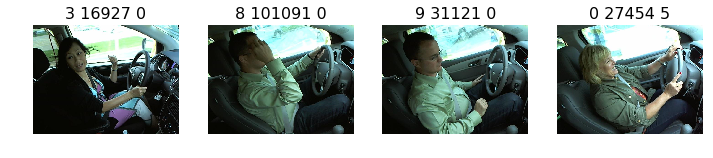

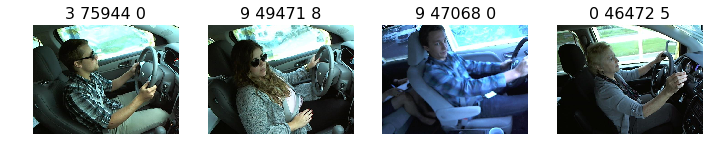

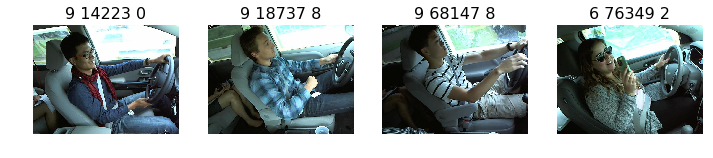

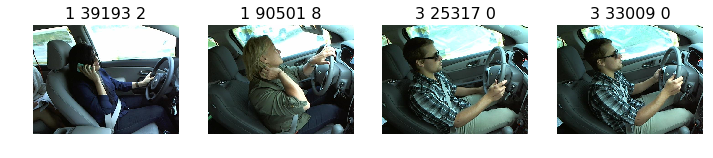

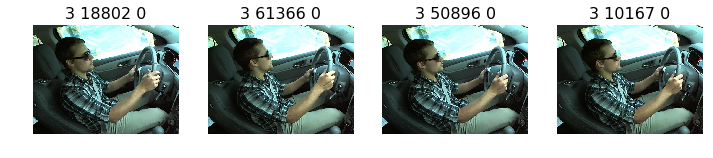

In [25]:
stride = 4
n_view = 20
nstrides = int(n_view/stride)
last_step = 0
for i in range(0,nstrides):
    next_step = min(last_step+stride, n_view-1)
    str(i) + " " + str(last_step) + " " + str(next_step)
    plots_idx(itemindex[last_step:last_step+stride],title[last_step:last_step+stride])
    last_step = last_step+stride

In [26]:
# Above looks not too bad except for a couple of images in which it looks like it is a case of radio + talking
# to the passenger, plus one stripey arm looks to be no where near the radio. Also the blonde lady looks like she is 
# driving only with right arm which might suggest texting with left. Asian lady is smiling intensely 
# (looks like talking)
# Either reduce the weighting of these images, or use bounding boxes for cup_can, mobile phone, 

# Other photos may be difficult because of hat, sunglasses, stripey shirt, makeup mirror is down or leaning forward.  
# Increase the weighting of these images.

## Evaluate the Model using Independent Subjects for Validation

In [27]:
#evaluate(self, x, y, batch_size=32, verbose=1, sample_weight=None)
bn_model.evaluate(conv_val_feat, val_labels)

3832/3832 [==============================] - 1s     


[1.0746395986367772, 0.7466075155331845]

In [28]:
bn_model.metrics_names

['loss', 'acc']

## Ensemble Modelling

In [29]:
val_probs = bn_model.predict(conv_val_feat, batch_size=128, verbose=1)
#val_probs[:8]

3832/3832 [==============================] - 1s     


In [30]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

In [31]:
yfull_test = []

for index in range(1, folds + 1):
    # Store test predictions
    model = read_model(index, 'old')
    val_probs = bn_model.predict(conv_val_feat, batch_size=128, verbose=1)
    yfull_test.append(val_probs)
        
merged_probs = merge_several_folds_mean(yfull_test, folds)

3832/3832 [==============================] - 1s     


In [32]:
merged_pred_class = np.argmax(merged_probs, axis=1)
merged_pred_class[:8]

array([8, 3, 0, 3, 0, 0, 3, 0])

In [33]:
val_classes[:8]

array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [34]:
incorrect = np.where(merged_pred_class!=val_classes)[0]
len(incorrect)

971

In [35]:
len(incorrect)/len(val_classes)

0.25339248434237993

In [36]:
bn_model.save_weights(MODELS_DIR+'fc_bn_weights1b.h5')

In [37]:
from keras.models import load_model
#bn_model.save(MODELS_DIR+'fc_bn_model1.h5') #didn't work.

#### Next: Find the poorest predictions in the validation dataset and remove these. Repeat with choices of validation and training data progressively adding zero weights to a sample_weight masking vector which identifies all of the bad data.   After removing all of the bad data, commence modelling with data augmentation.